In [21]:
import os
from os.path import exists

import anchor
import anchor.anchor_tabular

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error

from sklearn.svm import SVC
from sklearn.base import BaseEstimator, ClassifierMixin

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import joblib
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, f1_score, recall_score
from sklearn.inspection import DecisionBoundaryDisplay


import operator as op
from AnchorGeneration import *
import re

In [2]:
data_path = "/Users/saranarteni/OneDrive - CNR/REXASI-PRO/T3.1/navground_code/simulation2/"
res_path = data_path+"resultsPSR_Safe/"
results_anchorfile = "anchors-psr.csv"
feature_labels = ["SafetyMargin","Eta","Tau"]
true_output = "y_true"
cp_output = "y_conformal"
#model_output = "y_pred"

rules = pd.read_csv(res_path+results_anchorfile)

model = joblib.load(data_path+"PS_SVM_safe.sav")

test = pd.read_csv(data_path+"test_ps.csv")
y_test = np.array(test[true_output])
#y_model_test = np.array(test[model_output])
y_cp_test = np.array(test[cp_output])
X_test_df = test.drop([true_output,cp_output],axis = 1)
X_test = np.array(X_test_df)



In [3]:
test.describe()

,SafetyMargin,Eta,Tau,y_true,y_conformal
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.050085,0.504349,0.494272,0.102000,-0.012000
std,0.029221,0.295552,0.291230,0.995282,1.000428
min,0.000020,0.001283,0.001622,-1.000000,-1.000000
25%,0.024422,0.242766,0.239571,-1.000000,-1.000000
50%,0.050102,0.523454,0.478116,1.000000,-1.000000
75%,0.076151,0.766107,0.759959,1.000000,1.000000
max,0.099955,0.999287,0.999445,1.000000,1.000000


In [4]:
# visualize the anchors for all test set
rules

,Index,AnchorConditions,Coverage,Precision,AnchorOutput,ModelOutput,RealOutput
0,0,Tau <= 0.25,0.2475,0.877076,1.0,1.0,1.0
1,1,Tau <= 0.25,0.2511,0.870536,1.0,1.0,1.0
2,2,SafetyMargin > 0.07,0.2481,0.866748,1.0,1.0,1.0
3,3,Tau <= 0.25,0.2523,0.844311,1.0,1.0,1.0
4,4,Tau <= 0.25,0.2538,0.871880,1.0,1.0,1.0
...,...,...,...,...,...,...,...
989,995,SafetyMargin <= 0.02,0.2543,0.836327,-1.0,-1.0,-1.0
990,996,Tau > 0.75,0.2520,0.836830,-1.0,-1.0,-1.0
991,997,SafetyMargin > 0.05,0.4855,0.721279,1.0,1.0,1.0
992,998,SafetyMargin <= 0.02,0.2486,0.843945,-1.0,-1.0,1.0


In [5]:
rules[rules["AnchorOutput"]==1]["AnchorConditions"].value_counts()

AnchorConditions
Tau <= 0.25            215
SafetyMargin > 0.07    149
Tau <= 0.51             66
SafetyMargin > 0.05     58
Eta > 0.76               5
Eta > 0.50               1
Name: count, dtype: int64

In [6]:
model.get_params()

{'alpha': array([0.49992162, 0.50003417, 0.49988513, ..., 0.50007678, 0.49997215,
        0.49994338]),
 'b': array([-0.05929787]),
 'b_eps': 0.21856089114097121,
 'eta': 0.3,
 'kernel': 'polynomial',
 'param': 3}

# Candidate selection

Text(0, 0.5, 'Count')

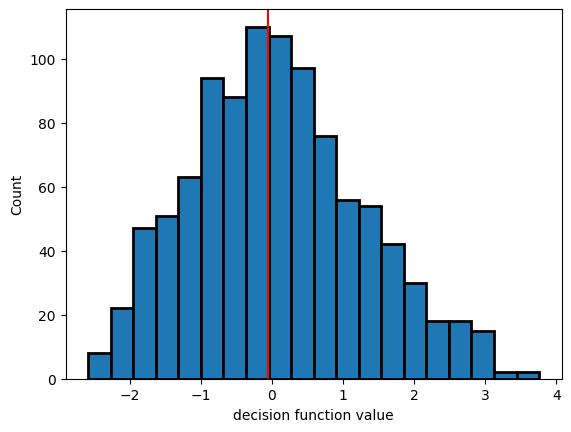

In [7]:
# distances of test points from decision boundary
d_test = model.decision_function(X_test)

plt.hist(d_test,bins = 20, edgecolor = "black",linewidth=2)
plt.gca().axvline(x=-0.05, color = "red")
plt.xlabel("decision function value")
plt.ylabel("Count")

In [8]:
model.b_eps

0.21856089114097121

In [9]:
d_thresh = 0.05

border_points_idx = np.where((d_test < 0) & (abs(d_test) < d_thresh) & (y_cp_test == 1))[0]

print(f"# of candidate points: {len(border_points_idx)}")

# of candidate points: 12


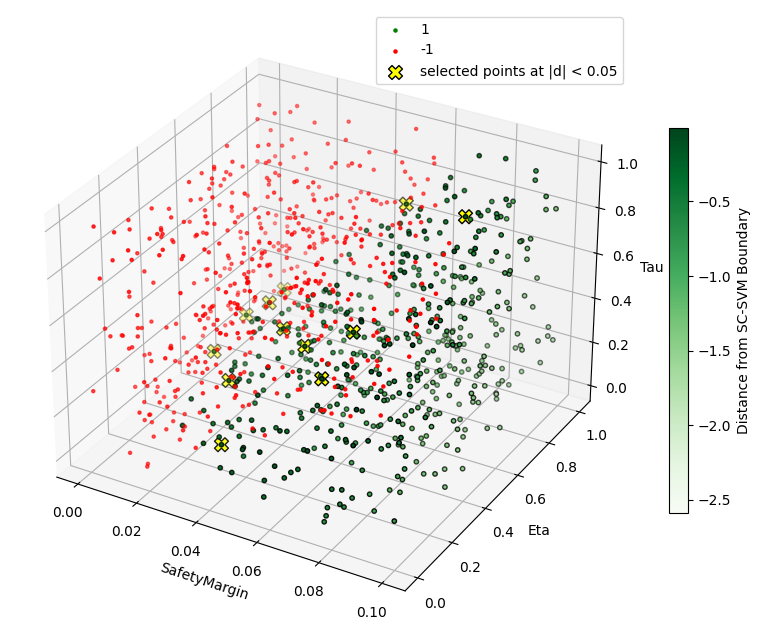

In [10]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(projection='3d')

sc0 = ax.scatter3D(X_test[:,0][y_cp_test == -1], X_test[:,1][y_cp_test == -1], X_test[:,2][y_cp_test == -1], s=5, c= "red")
scsafe = ax.scatter3D(X_test[:,0][y_cp_test == 1], X_test[:,1][y_cp_test == 1], X_test[:,2][y_cp_test == 1], s=5, c= "green")

sc1 = ax.scatter3D(X_test[:,0][y_cp_test == 1], X_test[:,1][y_cp_test == 1], X_test[:,2][y_cp_test == 1], s=10, c=d_test[y_cp_test == 1], cmap = "Greens", edgecolors = "k")

sc2 = ax.scatter3D(X_test[list(border_points_idx),0],X_test[list(border_points_idx),1], X_test[list(border_points_idx),2],s=100, marker = 'X', facecolors="yellow", edgecolors="k")


ax.set_xlabel("SafetyMargin")
ax.set_ylabel("Eta")
ax.set_zlabel("Tau")



ax.legend([scsafe, sc0,sc2], ["1","-1",f"selected points at |d| < {d_thresh}"], loc="upper right")
plt.colorbar(sc1, label = "Distance from SC-SVM Boundary", shrink = 0.5)

plt.show()

# Select the anchors for the candidate points

In [11]:
rule_cand_idx = np.array(rules[rules["Index"].isin(border_points_idx)==True].index)

In [12]:
# get rules generated on the selected boundary points
rules_candidates = rules.iloc[rule_cand_idx,:]

In [13]:
# focus on non collision class (label +1)
rules_noncoll = rules_candidates[rules_candidates["AnchorOutput"] == 1]
'''
# define a threshold for filtering on covering
covering_threshold = 0.1

rules_selected = rules_noncoll[rules_noncoll["Coverage"]>= covering_threshold]

rules_selected = rules_selected.sort_values(by = ["Coverage"], axis = 0, ascending = False)

rules_selected
'''

'\n# define a threshold for filtering on covering\ncovering_threshold = 0.1\n\nrules_selected = rules_noncoll[rules_noncoll["Coverage"]>= covering_threshold]\n\nrules_selected = rules_selected.sort_values(by = ["Coverage"], axis = 0, ascending = False)\n\nrules_selected\n'

In [14]:
rules_noncoll["AnchorConditions"].value_counts()

AnchorConditions
Tau <= 0.25            5
Tau <= 0.51            4
SafetyMargin > 0.05    2
SafetyMargin > 0.07    1
Name: count, dtype: int64

# Performance Evaluation


In [15]:
def evaluate_rules(data, tuned_rules, output):
    predictions_all = []
    for i, rule in tuned_rules.iterrows():
        pred_rule = []
        tptot = 0
        tntot = 0
        fntot = 0
        fptot = 0
        tuned_antecedent = rule['AnchorConditions'].strip()
        print(f"rule: {tuned_antecedent}")
        for _, row in data.iterrows():
            y_row = row[output]
            tp = 0
            tn = 0
            fn = 0
            fp = 0
            # check if the point row satifies rule 
            if evaluate_rule_conditions(row, tuned_antecedent):
                # rule is satisfied
                satisfied = True
                pred_rule.append(1)
            else:
                satisfied = False
                pred_rule.append(-1)
    
            
            if satisfied and y_row == 1:
                tp=1
            elif satisfied and y_row == -1:
                fp=1
            elif not satisfied and y_row == -1:
                tn=1
            
            elif not satisfied and y_row == 1:
                fn=1
            predictions_all.append(pred_rule)
            tptot+=tp
            tntot+=tn
            fptot+=fp
            fntot+=fn

        
        print(f"tp = {tptot}, tn = {tntot}, fp = {fptot}, fn = {fntot}")
        prec = tptot / (tptot+fptot)
        cov = tptot/(tptot+fntot)
        acc = (tptot+tntot)/(tptot+tntot+fptot+fntot)
        f1score = (2*tptot)/(2*tptot+fptot+fntot)
        error = fptot/(fptot+tntot)
        print(f"precision: {prec}, covering: {cov}, error: {error}, accuracy: {acc}, f1: {f1score}\n")          

    return predictions_all


def evaluate_rule_conditions(row, condition_part):

    # Checks if any of the conditions in the rule are satisfied
    if all(check_condition(row, part) for part in condition_part.split(" AND ")):
        return True  # Return True if all conditions in the rule are satisfied
    
    return False  # Return False if any of the conditions in the rule is not satisfied


def check_condition(row, condition_part):
    # Check if a single condition part is satisfied
    
    parts = re.split(r'\s*(==|<=|>=|<|>|!=)\s*', condition_part.split('()')
    #print("parts: ", parts)
    if len(parts) == 3:
        column, op, value = parts
        return eval(f"{row[column]} {op} {value}")
    # handle the case of a 2-thresholds conditions of the kind: a < Column <= b
    elif len(parts) == 5:
        val1,op1,column,op2,val2 = parts
        # Use the original condition from the rule
        return eval(f"{val1} {op1} {row[column]} {op2} {val2}")        
    else:
        # Handle cases where the condition is not in the expected format
        pass



In [16]:
rules_noncoll_unique = rules_noncoll.drop_duplicates(subset = "AnchorConditions")
rules_noncoll_unique

,Index,AnchorConditions,Coverage,Precision,AnchorOutput,ModelOutput,RealOutput
21,21,Tau <= 0.51,0.4990,0.753117,1.0,1.0,-1.0
38,39,SafetyMargin > 0.05,0.5019,0.730906,1.0,1.0,1.0
71,73,Tau <= 0.25,0.2451,0.885287,1.0,1.0,1.0
552,555,SafetyMargin > 0.07,0.2503,0.808276,1.0,1.0,1.0


# Evaluation on true labels

In [17]:
preds_by_rule = evaluate_rules(test, rules_noncoll_unique, true_output)

rule: Tau <= 0.51
tp = 374, tn = 295, fp = 154, fn = 177
precision: 0.7083333333333334, covering: 0.6787658802177858, error: 0.3429844097995546, accuracy: 0.669, f1: 0.6932344763670065

rule: SafetyMargin > 0.05
tp = 417, tn = 362, fp = 87, fn = 134
precision: 0.8273809523809523, covering: 0.7568058076225045, error: 0.19376391982182628, accuracy: 0.779, f1: 0.790521327014218

rule: Tau <= 0.25
tp = 202, tn = 391, fp = 58, fn = 349
precision: 0.7769230769230769, covering: 0.3666061705989111, error: 0.1291759465478842, accuracy: 0.593, f1: 0.49815043156596794

rule: SafetyMargin > 0.07
tp = 273, tn = 410, fp = 39, fn = 278
precision: 0.875, covering: 0.4954627949183303, error: 0.08685968819599109, accuracy: 0.683, f1: 0.6326767091541136



# evaluation on safety checker labels

In [18]:
preds_by_rule_cp = evaluate_rules(test, rules_noncoll_unique, cp_output)

rule: Tau <= 0.51
tp = 374, tn = 352, fp = 154, fn = 120
precision: 0.7083333333333334, covering: 0.757085020242915, error: 0.30434782608695654, accuracy: 0.726, f1: 0.7318982387475538

rule: SafetyMargin > 0.05
tp = 372, tn = 374, fp = 132, fn = 122
precision: 0.7380952380952381, covering: 0.7530364372469636, error: 0.2608695652173913, accuracy: 0.746, f1: 0.7454909819639278

rule: Tau <= 0.25
tp = 220, tn = 466, fp = 40, fn = 274
precision: 0.8461538461538461, covering: 0.44534412955465585, error: 0.07905138339920949, accuracy: 0.686, f1: 0.583554376657825

rule: SafetyMargin > 0.07
tp = 252, tn = 446, fp = 60, fn = 242
precision: 0.8076923076923077, covering: 0.5101214574898786, error: 0.11857707509881422, accuracy: 0.698, f1: 0.6253101736972705



**Evaluate the $\lor$ of the rules**

In [19]:
verified1 = (X_test[:,0] > 0.07) 

verified2 = (X_test[:,2] <= 0.25) 

verified_or = verified1|verified2
prec, cov, acc, fscore, err = ComputeMetricsForRule(verified_or, y_test)
print(f"precision: {prec}, covering: {cov}, accuracy: {acc}, f1: {fscore}, error: {err}")                                                             

tp = 390, tn = 352, fp = 97, fn = 161
precision: 0.8008213552361396, covering: 0.7078039927404719, accuracy: 0.742, f1: 0.7514450867052023, error: 0.19917864476386038


In [20]:
prec, cov, acc, fscore,err = ComputeMetricsForRule(verified_or, y_cp_test)
print(f"precision: {prec}, covering: {cov}, accuracy: {acc}, f1: {fscore}, error: {err}")   

tp = 387, tn = 406, fp = 100, fn = 107
precision: 0.7946611909650924, covering: 0.7834008097165992, accuracy: 0.793, f1: 0.7889908256880734, error: 0.2053388090349076
